# Project 2 - Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization




### Read Data

In [1]:
# imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm 
import numpy as np

plt.style.use('seaborn-v0_8-dark')

In [2]:
# from pathlib import Path 
import pathlib as pl

HOME                = pl.Path.home()
PROJECTS            = "Projects"
STAT                = "STAT_159_259"
PROJ_GRP            = "proj02-group08"

DIR_CODE            = HOME / PROJECTS / STAT / PROJ_GRP / "code"
DIR_DATA            = HOME / PROJECTS / STAT / PROJ_GRP / "data" 
DIR_DATA_RAW        = DIR_DATA / "00_raw"
DIR_DATA_PROCESSED  = DIR_DATA / "01_processed"
DIR_DATA_VECTORIZED = DIR_DATA / "02_vectorized"
DIR_DOCS            = HOME / PROJECTS / STAT / PROJ_GRP / "docs"
DIR_MISC            = HOME / PROJECTS / STAT / PROJ_GRP / "misc"
DIR_NOTEBOOKS       = HOME / PROJECTS / STAT / PROJ_GRP / "notebooks"
DIR_OUTPUTS         = HOME / PROJECTS / STAT / PROJ_GRP / "outputs"
DIR_TESTS           = HOME / PROJECTS / STAT / PROJ_GRP / "tests"

In [3]:
# sou = pd.read_csv(
#     Path.home() / "proj02-group08" / "data" / "00_raw" / "SOTU.csv"
# )
sou = pd.read_csv(DIR_DATA_RAW / "SOTU.csv")

In [4]:
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


### Processing Speeches with SpaCy

In [5]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [6]:
# subset the speech dataframe for speeches from 2000 and onwards
after_2000 = sou[sou["Year"] >= 2000].copy()


In [7]:
# Process each speeches using the 'nlp' function
nlp_outputs = [
    nlp(txt)
    for txt in tqdm(after_2000["Text"], desc="Analyzing speeches (>= 2000) with spaCy")
]


Analyzing speeches (>= 2000) with spaCy: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


### Analyze Tokens vs Lemmas

In [8]:
from collections import Counter

tokens_filtered = []


for doc in nlp_outputs:
    for tok in doc:
        if tok.is_space:
            continue
        if tok.is_stop:
            continue
        if tok.is_punct:
            continue
            
        tokens_filtered.append(tok.text.lower())

In [9]:
# print top 20 tokens

token_count = Counter(tokens_filtered)

top_20 = sorted(token_count.items(), key=lambda x: x[1], reverse=True)[:20]
top_20



[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255)]

#### Lemma List

In [10]:
lemmas_filtered = []

for doc in nlp_outputs:
    for tok in doc:
        if tok.is_space:
            continue
        if tok.is_stop:
            continue
        if tok.is_punct:
            continue
            
        lemmas_filtered.append(tok.lemma_.lower())

lemma_count = Counter(lemmas_filtered)

top_20_lemmas = sorted(lemma_count.items(), key=lambda x: x[1], reverse=True)[:20]
top_20_lemmas


[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301)]

#### Token versus Lemma Comparison

In the token counts, “year” (406) and “years” (439) appear as two separate items, but the lemma “year” merges them into 845 total occurrences, making it the most frequent concept overall. Lemmatization also highlights words that would otherwise get overlooked. For example, “child” doesn’t appear in the top token list at all, yet the lemma “child” shows up 332 times once forms like “children” and “child’s” are mapped back to the same base word. Overall, lemmatization gives a clearer sense of the underlying topics in the speeches by grouping variations of the same word, instead of treating them as separate terms.

### Common Words

#### Common Words per Year Function

In [11]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    
    inputs: 
    - df raw unprocessed sou dataframe
    - year
    - n
    outputs: 
    - top n words for that years
    """

    # Step 1: Subset df
    filtered_speeches = df[df["Year"].astype(int) == int(year)]
    
    if filtered_speeches.empty:
        return []

    # Step 2: Process the text with spaCy
    extracted_lemmas = []
    for speech_text in tqdm(filtered_speeches['Text'], desc=f"Processing {year}"):
        processed_doc = nlp(speech_text)
        
        # Step 3: Get lemmas
        for token in processed_doc:
            if token.is_space:
                continue
            if token.is_stop:
                continue
            if token.is_punct:
                continue
            extracted_lemmas.append(token.lemma_.lower())
    lemma_counts = Counter(extracted_lemmas)
    return lemma_counts.most_common(n)


In [12]:
get_most_common_words(sou, 2024, n=10)

Processing 2024: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29)]

#### Compare 2023 to 2017


In [13]:
words_2023 = get_most_common_words(sou, 2023, n=20)
words_2017 = get_most_common_words(sou, 2017, n=20)

Processing 2017: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [14]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [15]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [16]:
df_2017 = pd.DataFrame(words_2017, columns=["word", "count"])
df_2023 = pd.DataFrame(words_2023, columns=["word", "count"])
df_2023.head(), df_2017.head()


(     word  count
 0    year     58
 1      go     56
 2     let     45
 3    know     40
 4  people     39,
        word  count
 0  american     34
 1   america     29
 2   country     26
 3    nation     21
 4     great     20)

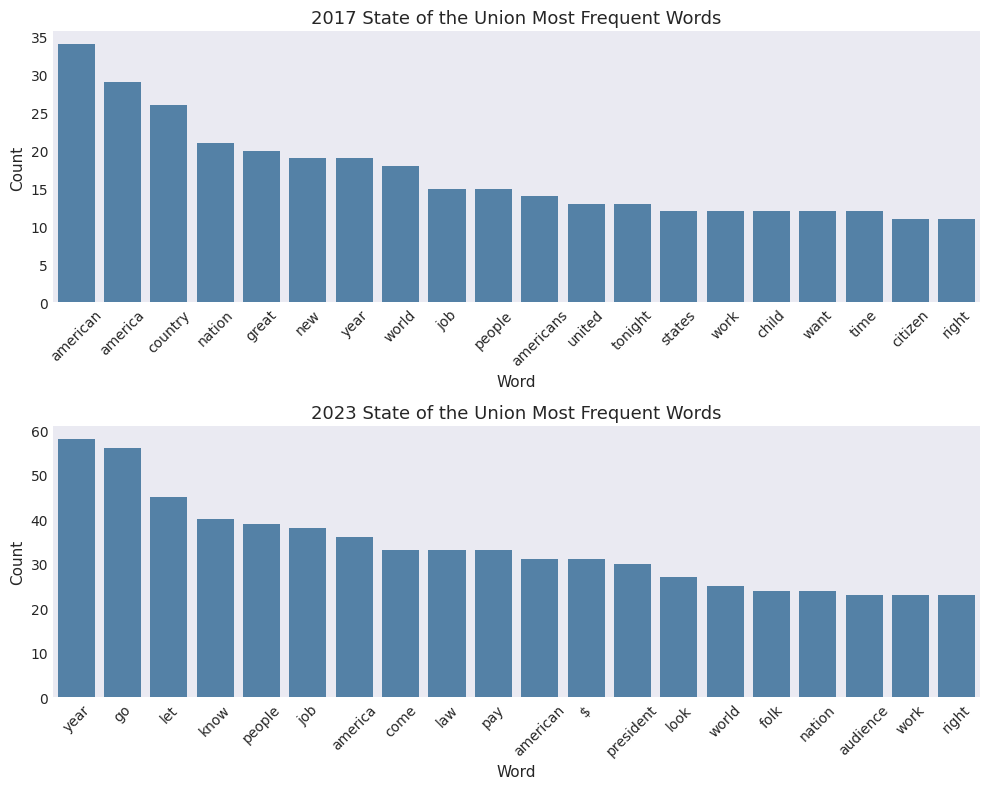

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

datasets = [(df_2017, '2017'), (df_2023, '2023')]

for ax, (dataset, year_str) in zip(axes, datasets):
    sns.barplot(data=dataset, x='word', y='count', ax=ax, color='steelblue')
    ax.set_title(f'{year_str} State of the Union Most Frequent Words', fontsize=13)
    ax.set_xlabel('Word', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DIR_OUTPUTS / "top_words_2017_2023.png", dpi=300)
plt.show()

### TF-IDF Vectorization

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [19]:
raw_docs = sou["Text"].to_list()

In [20]:
tfidf_model = TfidfVectorizer()
speech_vectors = tfidf_model.fit_transform(raw_docs)

print(f"Vectorized documents shape: {speech_vectors.shape}")

Vectorized documents shape: (246, 25957)


#### Plot Speeches


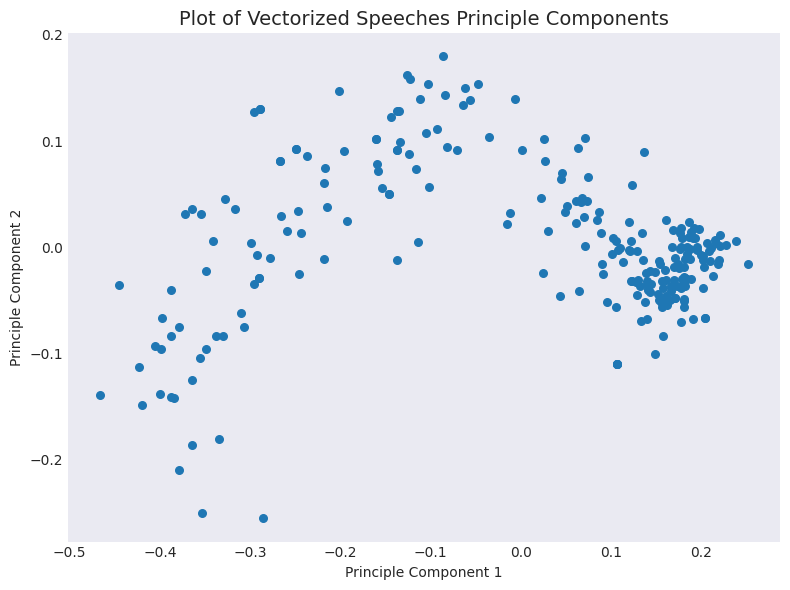

In [21]:
pca = PCA(n_components=2, random_state=42)

df2d = pd.DataFrame(
    pca.fit_transform(speech_vectors.toarray()), 
    columns=['Principle Component 1', 'Principle Component 2']
)

ax = df2d.plot(kind='scatter', x='Principle Component 1', y='Principle Component 2', 
          figsize=(8, 6), s=30)
plt.title('Plot of Vectorized Speeches Principle Components', fontsize=14)
plt.tight_layout()
plt.savefig(DIR_OUTPUTS / "vectorized_speeches_scatterplot_PCA.png", dpi=300)
plt.show()

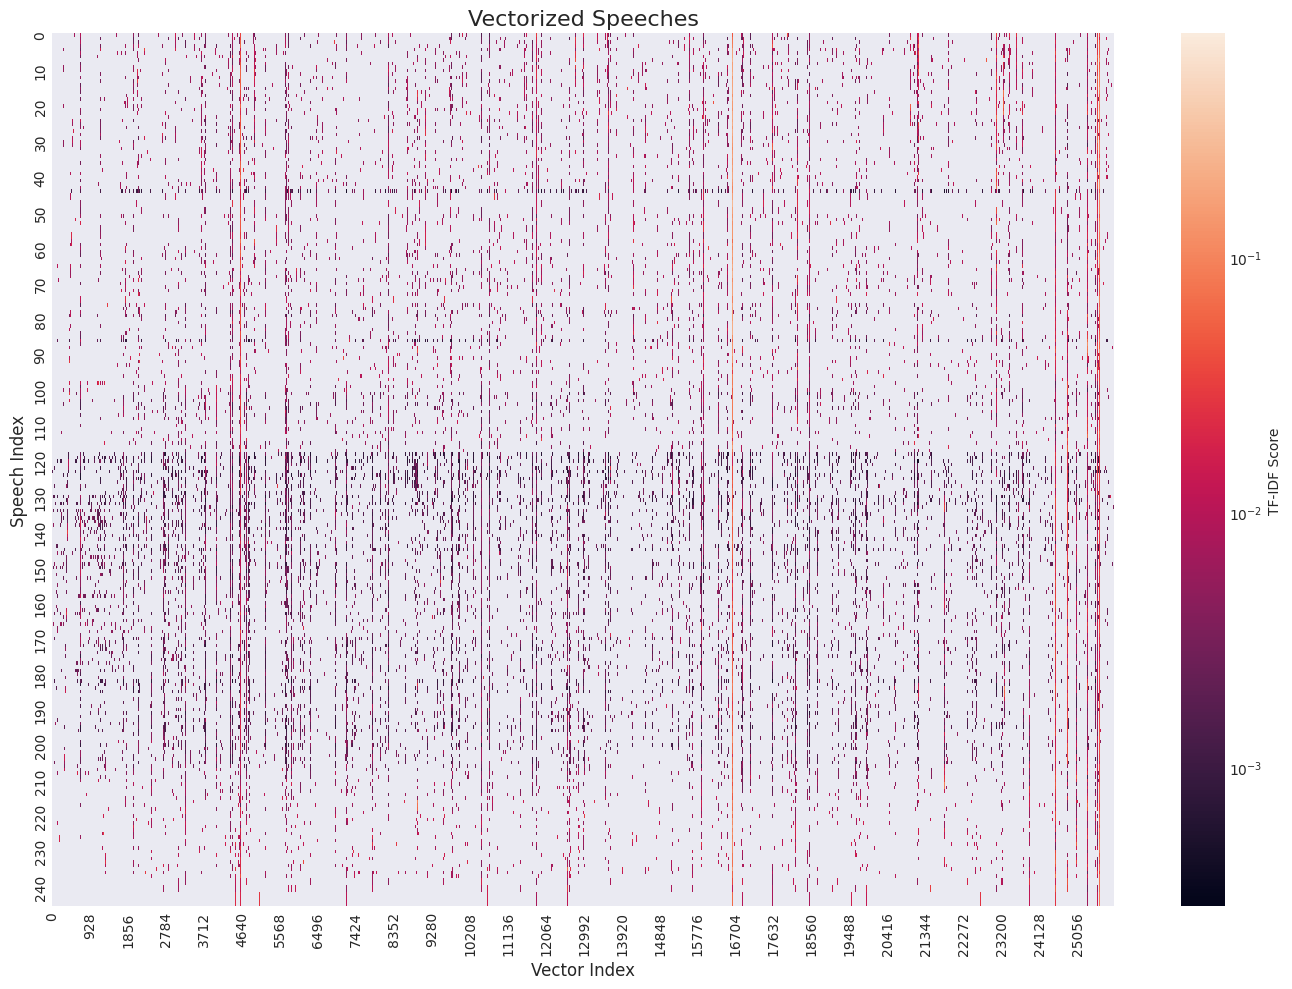

In [22]:
densify_array = speech_vectors.toarray()

plt.figure(figsize=(14, 10))

sns.heatmap(
    densify_array,
    cmap="rocket",  
    norm=LogNorm(),  
    cbar_kws={'label': 'TF-IDF Score'},
    xticklabels=928,  
    yticklabels=10     
)

plt.title("Vectorized Speeches", fontsize=16)
plt.xlabel("Vector Index", fontsize=12)
plt.ylabel("Speech Index", fontsize=12)
plt.tight_layout()
plt.savefig(DIR_OUTPUTS / "vectorized_speeches_heatmap.png", dpi=300)
plt.show()

#### Get the TF-IDF value for certain words and documents

In [23]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [24]:
word_nums = [tfidf_model.vocabulary_[word] for word in word_list]

In [25]:
idf_score = [tfidf_model.idf_[idx] for idx in word_nums] 

In [26]:
first_speech_vector = speech_vectors[0].toarray().flatten()
tf_idf = [first_speech_vector[idx] for idx in word_nums] 

In [27]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
